In [1]:
using LinearAlgebra
using SparseArrays
using Plots

function xy(
    x0::Float64, 
    y0::Float64, 
    L1::Float64, 
    L2::Float64, 
    noelms1::Int64, 
    noelms2::Int64
)::Tuple{Vector{Float64}, Vector{Float64}}
    VX = repeat(collect(LinRange(x0, x0+L1, noelms1+1)), inner=noelms2+1)
    VY = repeat(collect(LinRange(y0+L2, y0, noelms2+1)), noelms1+1)
    return VX, VY
end

function conelmtab(noelms1::Int64, noelms2::Int64)::Matrix{Int64}
    k = [i for i in 1:(noelms1*(noelms2+1)) if i % (noelms2+1) != 0]

    return [
        k (2 + noelms2 .+ k) (1 + noelms2 .+ k);
        k (1 .+ k) (2 + noelms2 .+ k)
    ]
end

function basfun(
    VX::Vector{Float64}, 
    VY::Vector{Float64}, 
    EToV::Matrix{Int64}
)::Tuple{Matrix{Float64}, Matrix{Float64}, Matrix{Float64}}
    xj = VX[EToV[:, [2,3,1]]]
    yj = VY[EToV[:, [2,3,1]]]

    xk = VX[EToV[:, [3,1,2]]]
    yk = VY[EToV[:, [3,1,2]]]

    at = xj .* yk - xk .* yj
    bt = yj - yk
    ct = xk - xj

    return at, bt, ct
end

function constructBeds(
    VX::Vector{Float64},
    VY::Vector{Float64},
    EToV::Matrix{Int64},
    tol::Float64,
    fd::Function,
)::Matrix{Int64}
    xc = (VX[EToV] + VX[EToV[:, [2, 3, 1]]]) ./ 2
    yc = (VY[EToV] + VY[EToV[:, [2, 3, 1]]]) ./ 2
    return getindex.(findall(abs.(fd.(xc, yc)) .<= tol), [1 2])
end

function constructBnodes(
    VX::Vector{Float64},
    VY::Vector{Float64},
    tol::Float64,
    fd::Function,
)::Vector{Int64}
    return findall(abs.(fd.(VX, VY)) .<= tol)
end

constructBnodes (generic function with 1 method)

In [2]:
function assembly(
    VX::Vector{Float64},
    VY::Vector{Float64},
    EToV::Matrix{Int64},
    lam1::Float64,
    lam2::Float64,
    qt::Vector{Float64},
    c::Vector{Float64}
)::Tuple{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Vector{Float64}}
    N = size(EToV)[1]
    M = length(VX)

    A = spzeros(M, M)
    C = spzeros(M, M)
    b = zeros(M)

    at, bt, ct = basfun(VX, VY, EToV)

    for n in 1:N
        abs_delta_n = abs(sum(at[n, :]) / 2)
        btn = bt[n, :]
        ctn = ct[n, :]

        EToV_n = EToV[n,:]
        qtn = abs_delta_n * sum(qt[EToV_n]) / 9
        cn = sum(c[EToV_n]) / 3

        for r in 1:3
            i = EToV_n[r]
            b[i] += qtn

            for s in r:3
                j = EToV_n[s]

                ij_min = min(i, j)
                ij_max = max(i, j)
                
                A[ij_min, ij_max] += (lam1*btn[r]*btn[s] + lam2*ctn[r]*ctn[s]) / (4 * abs_delta_n)
                C[ij_min, ij_max] += cn * abs_delta_n * (1 + (r == s)) / 12
            end
        end
    end

    return A, C, b
end

function dirbc(
    bnodes::Vector{Int64}, 
    f::Vector{Float64}, 
    A::SparseMatrixCSC{Float64, Int64}, 
    C::SparseMatrixCSC{Float64, Int64}, 
    b::Vector{Float64}
)::Tuple{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Vector{Float64}, Vector{Float64}}
    d = zeros(length(b))

    for (i, k) in enumerate(bnodes)
        b[k] = 0
        A[k, k] = 0
        C[k, k] = 1

        indices1 = findall(A[1:k-1, k] .!= 0)
        indices2 = findall(A[k, 1+k:end] .!= 0) .+ k

        temp1 = A[indices1,k] .* f[i]
        temp2 = A[k,indices2] .* f[i]

        b[indices1] -= temp1
        b[indices2] -= temp2

        d[indices1] += temp1
        d[indices2] += temp2

        A[indices1, k] .= 0
        A[k, indices2] .= 0

        indices1 = findall(C[1:k-1, k] .!= 0)
        indices2 = findall(C[k, 1+k:end] .!= 0) .+ k

        C[indices1, k] .= 0
        C[k, indices2] .= 0
    end

    return A, C, b, d
end

function solve_time_depedent_dirchlet_BVP(
    VX::Vector{Float64},
    VY::Vector{Float64},
    EToV::Matrix{Int64},
    lam1::Float64,
    lam2::Float64,
    qt::Function,
    c::Function,
    f::Function,
    fd_gamma::Function,
    tol::Float64,
    theta::Float64,
    u0::Vector{Float64},
    dt::Float64,
    N::Int64
)::Matrix{Float64}
    R, S, b = assembly(VX, VY, EToV, lam1, lam2, qt.(VX, VY), c.(VX, VY))

    bnodes = constructBnodes(VX, VY, tol, fd_gamma)
    R, S, b = dirbc(bnodes, f.(VX[bnodes], VY[bnodes]), R, S, b)

    M = length(VX)
    u = zeros(N+1, M)
    u[1, :] = u0

    d1 = dt * theta
    d2 = dt * (1.0 - theta)
    S -= d2 * R
    R = S + dt * R

    display(spy(R, markersize=5))
    display(spy(S, markersize=5))

    R = Symmetric(R)
    S = Symmetric(S)

    for n in 1:N
        e = S * u[n, :]
        u[n+1, :] = R \ e
    end

    return u
end

function solve_square_time_depedent_dirchlet_BVP(
    x0::Float64, 
    y0::Float64, 
    L1::Float64, 
    L2::Float64, 
    noelms1::Int64, 
    noelms2::Int64, 
    lam1::Float64,
    lam2::Float64,
    qt::Function,
    c::Function,
    f::Function,
    theta::Float64,
    g::Function,
    dt::Float64,
    N::Int64
)::Tuple{Vector{Float64}, Vector{Float64}, Matrix{Float64}}
    fd_gamma(x, y) = min(x - x0, y - y0, x0 + L1 - x, y0 + L2 - y)
    tol = 0.0001

    VX, VY = xy(x0, y0, L1, L2, noelms1, noelms2)
    EToV = conelmtab(noelms1, noelms2)

    u = solve_time_depedent_dirchlet_BVP(VX,VY,EToV,lam1,lam2,qt,c,f,fd_gamma,tol,theta,g.(VX, VY),dt,N)
    
    return VX, VY, u
end

solve_square_time_depedent_dirchlet_BVP (generic function with 1 method)

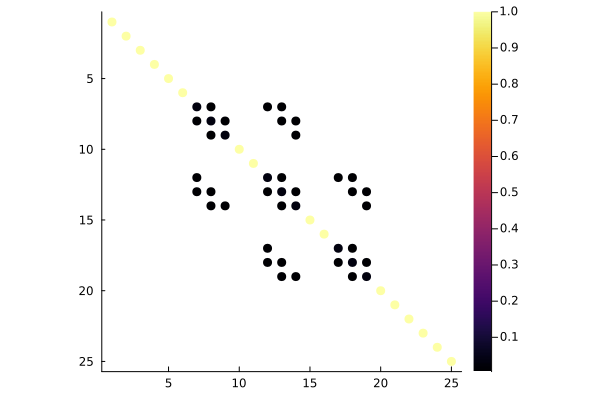

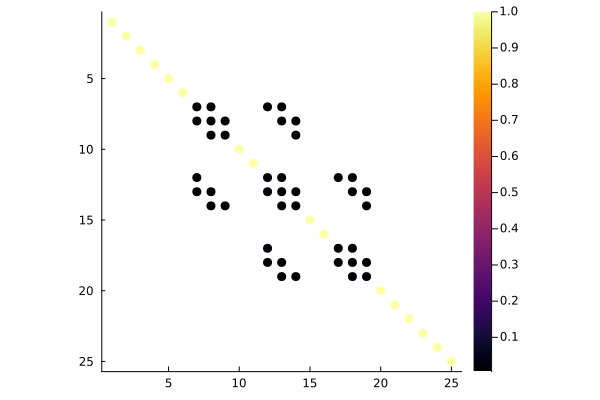

[ Info: Saved animation to /home/jakob/Uni/Fem/code/week 3/tmp.gif


Plots.AnimatedGif("/home/jakob/Uni/Fem/code/week 3/tmp.gif")
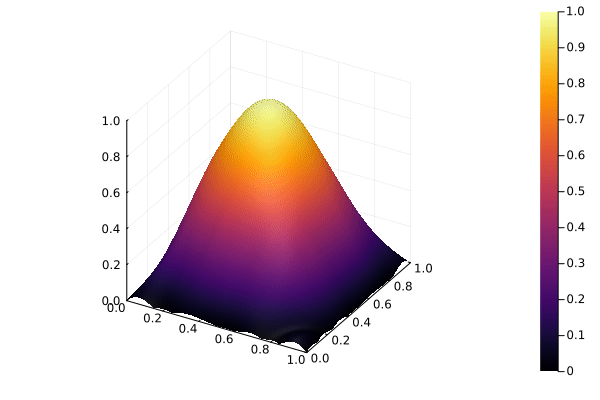

In [3]:
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0
noelms1 = 4
noelms2 = 4
lam1 = 1.0
lam2 = 1.0
qt(x,y) = 0.0
c(x,y) = 1.0
f(x, y) = 0.0
g(x, y) = sin(pi * x) * sin(pi * y)
theta = 0.0
dt = 0.005
N = 25

VX, VY, u = solve_square_time_depedent_dirchlet_BVP(
    x0,
    y0,
    L1,
    L2,
    noelms1,
    noelms2,
    lam1,
    lam2,
    qt,
    c,
    f,
    theta,
    g,
    dt,
    N
)

anim = @animate for i in 1:size(u)[1]
    plot(VX, VY, u[i, :], st=:surface, zlim=(0,1), clim=(0,1))
end

gif(anim, fps=10)